# Final Project: Text Analysis and Uncovering Demographic or Regional Differences in Family Caregiver Experiences

### *May Khine, Andrea Robang, Mark Lekina*

## Topic modeling notebook

### Load packages

In [1]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import nltk
import spacy
import en_core_web_sm
import gensim
import scipy as sp
from scipy.special import logsumexp
import matplotlib.pyplot as plt
from gensim.models.coherencemodel import CoherenceModel


## vectorizer
from sklearn.feature_extraction.text import CountVectorizer

## sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## lda
from gensim import corpora

## nltk imports
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

## load pipeline
nlp = en_core_web_sm.load()

## repeated printouts and wide-format text
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_colwidth', None)

### Load Data

In [2]:
# read data from excel file
data = pd.read_excel("../data/STARTFEISData.xlsx")

### Data cleaning

In [3]:
# Replace "â€™" with apostrophe(')
data.columns = data.columns.astype("string")
data.columns = data.columns.str.replace("â€™", "'")

# Replace "\n" with a space(" ")
data.columns = data.columns.str.replace("\n", " ")

## subset to columns with open responses
open_cols = [0,54,55,56]
open_data = data.iloc[:, open_cols].copy()

### Print head, dimensions

In [4]:
open_data.shape
open_data.head()

(1940, 4)

,Respondent ID # (SIRS Local ID),Was there any particular service that your family member needed that was not available?,"If yes, please describe the service.",What advice would you give to service planners regarding the mental health service needs of persons with IDD and their families?
0,43.0962,Yes,Crisis respite,None provided
1,1903,Yes,EMERGENCY RESPITE SERVICES & CRISIS INTERVENTION,PROVDE REFERRALS FOR EMERGENCY RESPITE SERVICES; JOB SUPPORT FOR ID CONSUMERS
2,2425,No,NaN,NaN
3,4068,No,NaN,NaN
4,4298,Yes,Crisis Response,NaN


### Topic modeling on the open data dataframe

1. What were the common responses for respondents who indicated that a service wasn't available?

In [5]:
# See unique values from those who answered No and Yes to quickly check if there are other answers
open_data_need = open_data.groupby(
    "Was there any particular service that your family member needed that was not available?").agg(
    {"If yes, please describe the service." : "unique"})

# Subset to those who answered Yes 
open_data_need = open_data.loc[open_data["Was there any particular service that your family member needed that was not available?"] == "Yes"].copy()

# Rename columns to make things easier
open_data_need.columns = ["ID", "In_Need", "Service", "Advice"]

open_data_need.head()

,ID,In_Need,Service,Advice
0,43.0962,Yes,Crisis respite,None provided
1,1903,Yes,EMERGENCY RESPITE SERVICES & CRISIS INTERVENTION,PROVDE REFERRALS FOR EMERGENCY RESPITE SERVICES; JOB SUPPORT FOR ID CONSUMERS
4,4298,Yes,Crisis Response,NaN
7,8799,Yes,would liek to have a medication eval,would like consultation with family before announcing prognosis to consumer
9,10045,Yes,community habilitation/big brother,nothing. they are doing the best that they can. It would be good for him to get out of the house more. we need help with transportation to help us get back into respite.


2. Write a preprocessing function to remove stopwords and apply it to the `Advice` column.

In [6]:
## Get stopwords
list_stopwords = stopwords.words("english")

## Initialize stemmer
porter = PorterStemmer()

In [7]:
## Define function to iterate through all responses 
def process_step(string):   
    try:
        nostop_listing = [word for word in wordpunct_tokenize(string)
                          if word not in list_stopwords]
        clean_listing = [porter.stem(word) for word in nostop_listing
                         if word.isalpha() 
                         and len(word) > 4]    # Can change length of word here 
        clean_listing_str = " ".join(clean_listing)    
        return(clean_listing_str)
    
    except:
        return("")

In [8]:
## Convert advice column to lowercase and a list
service_advice = open_data_need.Advice.str.lower().to_list()

# call function to preprocess each response
cleaned_listings = np.array([process_step(one_listing) for one_listing in 
                    service_advice])

# ## Add processed strings back to dataframe
open_data_need["proc_advice"] = open_data_need.Advice.apply(process_step)
open_data_need.head()

,ID,In_Need,Service,Advice,proc_advice
0,43.0962,Yes,Crisis respite,None provided,provid
1,1903,Yes,EMERGENCY RESPITE SERVICES & CRISIS INTERVENTION,PROVDE REFERRALS FOR EMERGENCY RESPITE SERVICES; JOB SUPPORT FOR ID CONSUMERS,provd referr emerg respit servic support consum
4,4298,Yes,Crisis Response,NaN,
7,8799,Yes,would liek to have a medication eval,would like consultation with family before announcing prognosis to consumer,would consult famili announc prognosi consum
9,10045,Yes,community habilitation/big brother,nothing. they are doing the best that they can. It would be good for him to get out of the house more. we need help with transportation to help us get back into respite.,noth would hous transport respit


### Functions for topic modelling

In [9]:
def prep_topicdata(df):
    # filtering out empty strings, words that do not appear in many documents
    df = df[df.proc_advice != ""].copy()
    tokenized_text = [wordpunct_tokenize(one_text) for one_text in 
                                      df.proc_advice]
    text_proc_dict = corpora.Dictionary(tokenized_text)
    text_proc_dict.filter_extremes(no_below = round(df.shape[0]*0.02),
                             no_above = round(df.shape[0]*0.98))
    
    corpus_fromdict_proc = [text_proc_dict.doc2bow(one_text) 
                   for one_text in tokenized_text]

    return tokenized_text, text_proc_dict, corpus_fromdict_proc

def topic_model(tokenized_text, text_proc_dict, corpus_fromdict_proc, topic_num):
        
    # create model
    ldamod = gensim.models.ldamodel.LdaModel(corpus_fromdict_proc, 
                                         num_topics = topic_num, id2word=text_proc_dict, 
                                         passes=6, alpha = 'auto',
                                        per_word_topics = True, random_state = 0)

    # get topics using frex values
    frex_words = create_topic_word_data(ldamod, corpus_fromdict_proc, frex_w=0.7)

    # get top 10 words per topic and collect in a list
    frex_topwords = frex_words.sort_values(['frex'], axis=0, ascending = False).groupby('topic').head(10)    
    frex_wordlist = frex_topwords.groupby('topic').agg({'word': [lambda x: list(x)]})
    frex_wordlist
    return(frex_wordlist)

def ecdf(arr):
    """Calculate the ECDF values for all elements in a 1D array."""
    return sp.stats.rankdata(arr, method='max') / arr.size


def frex(mod, w=0.7):
    """Calculate FREX for all words in a topic model.

    See R STM package for details.

    """
    log_beta = np.log(mod.get_topics())
    log_exclusivity = log_beta - logsumexp(log_beta, axis=0)
    exclusivity_ecdf = np.apply_along_axis(ecdf, 1, log_exclusivity)
    freq_ecdf = np.apply_along_axis(ecdf, 1, log_beta)
    out = 1. / (w / exclusivity_ecdf + (1 - w) / freq_ecdf)
    return out

def create_topic_word_data(mod, corpus, frex_w=0.7):
    """Create data frame with topic-word information.

    Parameters
    ------------
    mod: :class:`gensim.models.LdaModel`
        Fitted LDA model
    corpus: list
        Corpus in the same input format as required by
        :class:`gensim.models.LdaModel`.
    frex_w: float
        Weight to use in FREX calculations.
        
    Returns
    ---------
    :class:`pandas.DataFrame`
        Data frame with the following columns.


        :word: ``str``. Word
        :word_id: ``float``. Word identifier
        :topic: ``int``. Topic number
        :prob: ``float``. Probability of the word conditional on a topic.
        :frex: ``float``. FREX score
        :lift: ``float``. Lift score
        :relevance: ``float``. Relevance score

    """
    id2word = mod.id2word
    term_topics = pd.DataFrame(mod.get_topics())
    term_topics.index.name = "topic"
    term_topics.reset_index(inplace=True)
    words = pd.DataFrame({
        'word_id': list(id2word.keys()),
        'word': list(id2word.values())
        }, columns=("word_id", "word"))
    term_topics = pd.melt(term_topics, id_vars=["topic"],
                          var_name="word_id",
                          value_name="prob").\
        merge(words, left_on="word_id", right_on="word_id")
    term_topics['frex'] = np.ravel(frex(mod, w=frex_w), order="F")
    return term_topics


def compute_coherence_values(corpus_fromdict_proc, tokenized_text, text_proc_dict):
    # initialize possible # of topics in the range 2 to 10
    limit=10; start=2; step=1;
    coherence_values = []
    model_list = []
    
    # create models for each number of topics and coherence model values
    for num in range(start, limit, step):
        ldamod = gensim.models.ldamodel.LdaModel(corpus_fromdict_proc, 
                                                 num_topics = num, id2word=text_proc_dict, 
                                                 passes=20, alpha = 'auto',
                                                 per_word_topics = True, random_state = 0)    
        model_list.append(ldamod)
        coherencemodel = CoherenceModel(model=ldamod, texts=tokenized_text, dictionary=text_proc_dict, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())


    # Show graph
    x = range(start, limit, step)
    print(x)
    print(coherence_values)

    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

    return model_list, coherence_values

### Compute the optimal number of topics to use in the model

range(2, 10)
[0.27434511439149667, 0.3246528252353102, 0.31043234404799597, 0.292442096500731, 0.2841488638435777, 0.302894882749508, 0.2935461413780179, 0.2949770208332661]


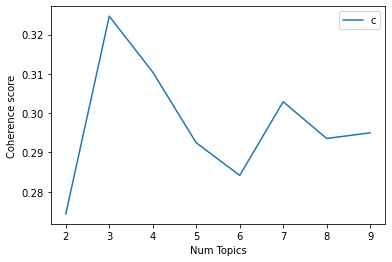

([<gensim.models.ldamodel.LdaModel at 0x7fb500329dc0>,
 [0.27434511439149667,
  0.3246528252353102,
  0.31043234404799597,
  0.292442096500731,
  0.2841488638435777,
  0.302894882749508,
  0.2935461413780179,
  0.2949770208332661])

In [10]:
# prepare data for topic modeling and coherence test
tokenized_text, text_proc_dict, corpus_fromdict_proc = prep_topicdata(open_data_need)

# compute coherence values for different #s of topics
compute_coherence_values(corpus_fromdict_proc, tokenized_text, text_proc_dict)

> From the graph, we can tell that our model performs relatively better when the **number of topics** is either 3 or 7

### Test model with the computed optimal number of topics

In [11]:
# perform topic modelling with two topics
three_topics = pd.DataFrame(topic_model(tokenized_text, text_proc_dict, corpus_fromdict_proc, 3))

# perform topic modelling with two topics
seven_topics = pd.DataFrame(topic_model(tokenized_text, text_proc_dict, corpus_fromdict_proc, 7))

three_topics.columns = ["top words"]
seven_topics.columns = ["top words"]

# display output
print(three_topics)
print()
print(seven_topics)

                                                                                top words
topic                                                                                    
0            [servic, commun, answer, provid, person, child, involv, avail, need, respit]
1      [health, listen, mental, individu, member, parent, caregiv, there, inform, famili]
2        [program, peopl, option, support, patient, educ, advoc, treatment, help, enough]

                                                                                       top words
topic                                                                                           
0                  [servic, provid, offer, would, need, follow, children, there, famili, inform]
1                 [answer, health, mental, children, disabl, respit, child, need, there, assist]
2              [patient, program, resourc, support, educ, respit, avail, treatment, would, work]
3                [peopl, option, listen, parent, advoc, medic, b